In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/jinyujie/anaconda3/envs/ga/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from unet import UNetModel
from ddpm import GaussianDiffusion

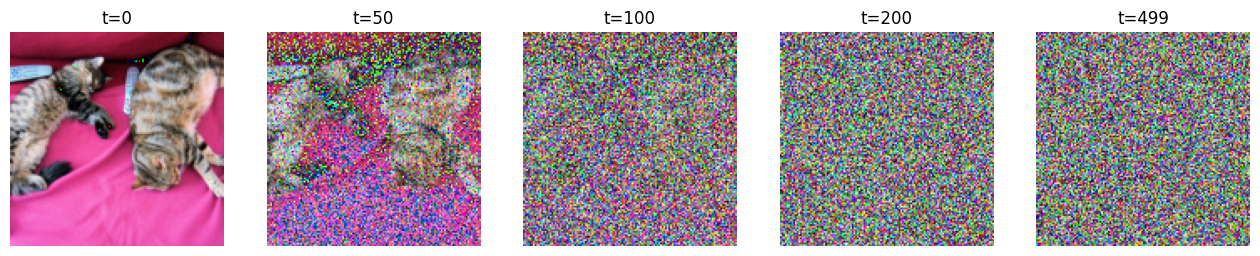

In [5]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/data/000000039769.jpg")

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


x_start = transform(image).unsqueeze(0)

timesteps = 500
gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

In [7]:
cwd = "/home/jinyujie/spirit/xiaoxiaojiang/ddpm"
checkpoints_path = os.path.join(cwd, "checkpoints", "tlight")
checkpoints_file = os.path.join(checkpoints_path, "model_9.pth")
checkpoints = torch.load(checkpoints_file, map_location=device)
model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=3,
    channel_mult=(1, 2, 2, 2),
    attention_resolutions=(2,),
    dropout=0.1
)
model.load_state_dict(checkpoints)
model = model.to(device)

In [8]:
generated_images = gaussian_diffusion.sample(model, (96, 32), batch_size=64, channels=3) # -1 to 1

sampling loop time step: 100%|██████████| 500/500 [00:35<00:00, 14.03it/s]


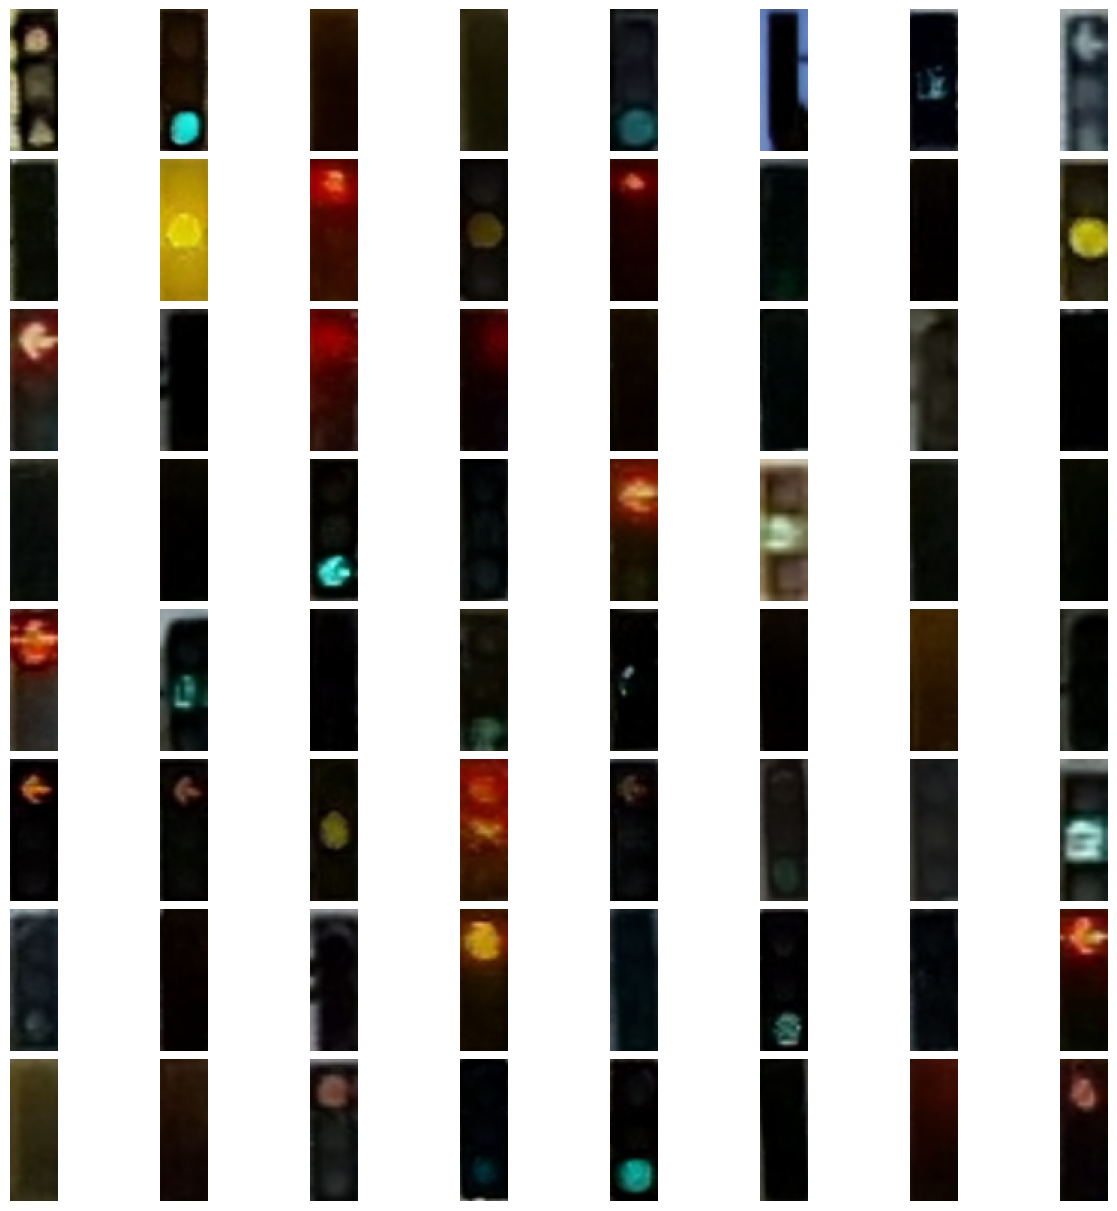

In [22]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 3, 96, 32)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = np.array((imgs[n_row, n_col].transpose([1, 2, 0])+1.0) * 255 / 2, dtype=np.uint8)
        f_ax.imshow(img)
        f_ax.axis("off")

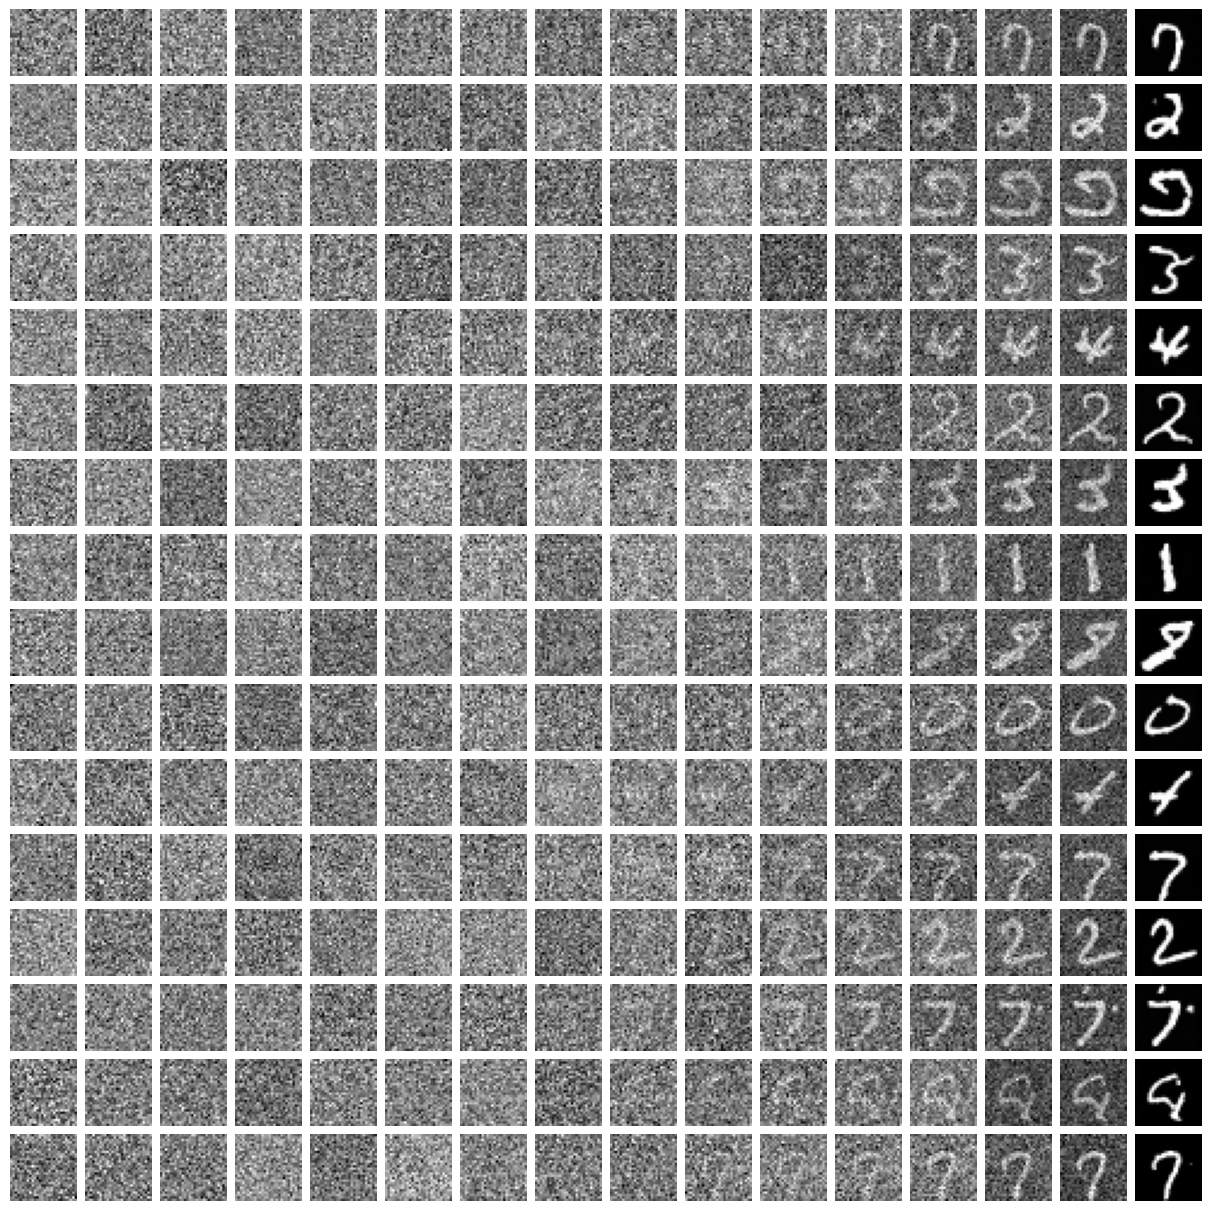

In [15]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

timesteps = 500
for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(28, 28)
        f_ax.imshow((img+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")